In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline
np.random.seed(111)
tf.set_random_seed(111)

In [4]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


In [5]:
sphere_center = 300. #m 
sphere_radius = 100. #m
density_difference = 500. # kg/m^3: density diffrence to surrounding domain
x_domain=np.linspace(-1000,1000,101) #m

In [6]:
x_obs = 0
# x_obs = np.linspace(-250, 250, 11)
grav_all = grav_analytical(x_domain, sphere_center, sphere_radius, density_difference)
grav_obs_array = grav_analytical(x_obs, sphere_center, sphere_radius, density_difference)
# noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_noise = grav_obs_array

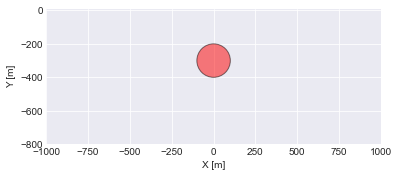

In [7]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center), sphere_radius, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.savefig('./Simple_grav_img/SG_noise_3_para/model.png')

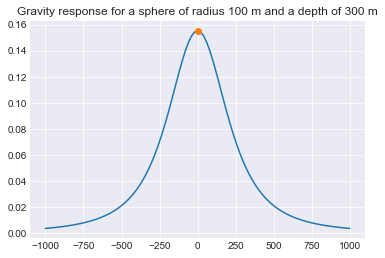

In [8]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_noise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");
plt.savefig('./Simple_grav_img/SG_noise_3_para/gravity.png')

In [9]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            # computing derivative twice, first w.r.t v2 and then w.r.t v1
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [10]:
# create a log-likelihood function
def grav_analytical_tf(x):
    
    sphere_center = ed.Normal(
            loc = 300,scale = 0, name = "sphere_center")
    density_difference = ed.Normal(
            loc = 500,scale = 0, name = "density_difference")
    sphere_radius = ed.Normal(
            loc = 100,scale = 0, name = "sphere_radius")
    G=6.67e-11 # gravitational constant
    
    gravity = ed.Normal(
        loc =(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ),
        scale = 0.01,
        name = "gravity")
    
    gravity = gravity - grav_obs_array_noise
    gradient = tf.gradients(gravity,[sphere_center,density_difference,sphere_radius])
    hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
    return gravity,gradient,hess




In [9]:
grav,grad,hess = grav_analytical_tf(x_obs)

W0917 12:28:27.848421 4613334464 deprecation.py:323] From /Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Calculate Gradient

In [10]:
# sum(dy/dx) wrt each x in xs
with tf.Session() as sess:
    print(sess.run([grad]))

[[-0.0010347862, 0.00031043592, 0.004656539]]


In [11]:
with tf.Session() as sess:
    print(sess.run([grav]))

[0.013688162]


### Calculation Hessian

In [12]:
with tf.Session() as sess:
    print(sess.run([hess]))


[array([[ 1.0347864e-05, -2.0695725e-06, -3.1043579e-05],
       [-2.0695725e-06,  0.0000000e+00,  9.3130766e-06],
       [-3.1043590e-05,  9.3130775e-06,  9.3130780e-05]], dtype=float32)]


### test multivariateNormal

In [13]:
mu = [300,500,100]
cov = [[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]]

mvn = tfd.MultivariateNormalFullCovariance(
        loc = mu,
        covariance_matrix= cov)
para = tfd.Sample(mvn)


In [14]:
mu = [1., 2., 3.]
cov = [[ 0.36,  0.12,  0.06],
       [ 0.12,  0.29, -0.13],
       [ 0.06, -0.13,  0.26]]
mvn = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=cov)


In [15]:
p1 = mvn.sample(1)

In [16]:
p1.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'MultivariateNormalFullCovariance_1/sample/affine_linear_operator/forward/add:0' shape=(1, 3) dtype=float32>>

In [17]:
with tf.Session() as sess:
    print(p1[0][0].eval())

0.8391874


In [ ]:
with tf.Session() as sess:
    print(p1[0][1].eval())

In [ ]:
mul = p1[0][0]*p1[0][1]

In [ ]:
with tf.Session() as sess:
    print(mul.eval())

In [ ]:
mu = [1., 2., 3.]
cov = [[ 0.36,  0.12,  0.06],
       [ 0.12,  0.29, -0.13],
       [ 0.06, -0.13,  0.26]]
mvn = ed.MultivariateNormalFullCovariance(
        loc = mu,
        covariance_matrix= cov)


In [ ]:
with tf.Session() as sess:
    print (mvn.eval())



# test Covariance Matrix




In [18]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            # computing derivative twice, first w.r.t v2 and then w.r.t v1
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [19]:
def grav_analytical_tf(x):
    # [sphere_center, density_difference, sphere_radius]
    mu = [300., 500., 100.]
    cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    
    gradient = tf.gradients(gravity,[sphere_center,density_difference,sphere_radius])
    hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
    
    return gravity,gradient,hess




In [20]:
grav,grad,hess = grav_analytical_tf(x_obs)

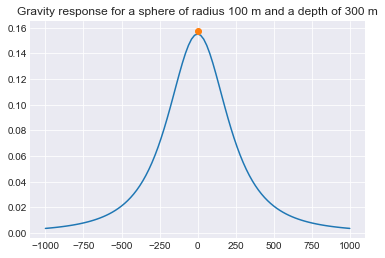

In [21]:
with tf.Session() as sess:
    a = grav.eval()
    plt.plot(x_domain, grav_all)
    plt.plot(x_obs, a, 'o', label="data")
    plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");
    plt.savefig('./Simple_grav_img/SG_noise_3_para/gravity.png')
    print()

In [146]:
hess

<tf.Tensor 'stack_7:0' shape=(3, 3) dtype=float32>

In [145]:
with tf.Session() as sess:
    print(sess.run([hess]))

[array([[ 1.04120245e-05, -2.09090308e-06, -3.11294934e-05],
       [-2.09090285e-06,  0.00000000e+00,  9.37695950e-06],
       [-3.11294898e-05,  9.37695950e-06,  9.30698152e-05]], dtype=float32)]


In [147]:
invhess = tf.linalg.inv(hess)


In [148]:
with tf.Session() as sess:
    print(sess.run([invhess]))

[array([[8.6438550e+05, 9.5652519e+05, 1.9274331e+05],
       [9.5652488e+05, 1.1133085e+00, 3.1993322e+05],
       [1.9274330e+05, 3.1993328e+05, 4.2978488e+04]], dtype=float32)]


### Gradient Decent test

In [2]:
import tensorflow as tf

x = tf.Variable(2, name='x', dtype=tf.float32)
log_x = tf.log(x)
log_x_squared = tf.square(log_x)

optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(log_x_squared)

init = tf.global_variables_initializer()

def optimize():
  with tf.Session() as session:
    session.run(init)
    print("starting at", "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
    for step in range(10):  
      session.run(train)
      print("step", step, "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
        

optimize()

starting at x: 2.0 log(x)^2: 0.480453
step 0 x: 1.6534264 log(x)^2: 0.25285786
step 1 x: 1.3493005 log(x)^2: 0.08975197
step 2 x: 1.1272696 log(x)^2: 0.014351669
step 3 x: 1.0209966 log(x)^2: 0.0004317743
step 4 x: 1.0006447 log(x)^2: 4.1534943e-07
step 5 x: 1.0000006 log(x)^2: 3.5527118e-13
step 6 x: 1.0 log(x)^2: 0.0
step 7 x: 1.0 log(x)^2: 0.0
step 8 x: 1.0 log(x)^2: 0.0
step 9 x: 1.0 log(x)^2: 0.0


In [11]:
x = tf.Variable(2, name='x', dtype=tf.float32)

y = tf.multiply(3.,tf.pow(x,2.) )

optimizer = tf.train.GradientDescentOptimizer(0.1)
train = optimizer.minimize(y)

init = tf.global_variables_initializer()


def optimize():
  with tf.Session() as session:
    session.run(init)
    print("starting at", "x:", session.run(x), "y = 3 * x^2:", session.run(y))
    for step in range(100):  
      session.run(train)
      print("step", step, "x:", session.run(x), "y = 3 * x^2:", session.run(y))
        
optimize()

W0923 15:09:54.072077 4499748288 deprecation.py:323] From /Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


starting at x: 2.0 y = 3 * x^2: 12.0
step 0 x: 0.79999995 y = 3 * x^2: 1.9199998
step 1 x: 0.31999996 y = 3 * x^2: 0.30719993
step 2 x: 0.12799998 y = 3 * x^2: 0.049151983
step 3 x: 0.051199988 y = 3 * x^2: 0.007864317
step 4 x: 0.020479994 y = 3 * x^2: 0.0012582904
step 5 x: 0.008191997 y = 3 * x^2: 0.00020132646
step 6 x: 0.0032767989 y = 3 * x^2: 3.2212232e-05
step 7 x: 0.0013107194 y = 3 * x^2: 5.153956e-06
step 8 x: 0.0005242877 y = 3 * x^2: 8.246327e-07
step 9 x: 0.00020971507 y = 3 * x^2: 1.3194123e-07
step 10 x: 8.388603e-05 y = 3 * x^2: 2.1110598e-08
step 11 x: 3.355441e-05 y = 3 * x^2: 3.3776955e-09
step 12 x: 1.3421764e-05 y = 3 * x^2: 5.4043126e-10
step 13 x: 5.3687054e-06 y = 3 * x^2: 8.646899e-11
step 14 x: 2.147482e-06 y = 3 * x^2: 1.3835037e-11
step 15 x: 8.5899285e-07 y = 3 * x^2: 2.213606e-12
step 16 x: 3.435971e-07 y = 3 * x^2: 3.541769e-13
step 17 x: 1.3743883e-07 y = 3 * x^2: 5.66683e-14
step 18 x: 5.497553e-08 y = 3 * x^2: 9.066927e-15
step 19 x: 2.199021e-08 y = 

### Gradient Decent to find MAP

In [40]:
def grav_analytical_tf(x):
    # [sphere_center, density_difference, sphere_radius]
    mu = [300., 500., 100.]
    cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 


    gradient = tf.gradients(gravity,[sphere_center,density_difference,sphere_radius])
    hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
    
    return gravity,gradient,hess



In [3]:
log_joint = ed.make_log_joint_fn(grav_analytical_tf)

#function to compute the log posteior prob

x_obs = tf.convert_to_tensor(x_obs,dtype = tf.float32)
grav_obs_array_noise = tf.convert_to_tensor(grav_obs_array_noise, dtype = tf.float32)

def target_log_prob_fn(sphere_center,density_difference,sphere_radius):
    return log_joint(
        x = x_obs, 
        sphere_center =sphere_center,
        density_difference = density_difference,
        sphere_radius = sphere_radius,
        
        gravity = grav_obs_array_noise
        )

NameError: name 'grav_analytical_tf' is not defined

In [42]:
target_log_prob_fn(sphere_center,density_difference,sphere_radius)

ValueError: slice index 0 of dimension 0 out of bounds. for 'strided_slice_1' (op: 'StridedSlice') with input shapes: [0], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.

In [ ]:
sphere_center = tf.Variable(300, name='sphere_center', dtype=tf.float32) #m 
sphere_radius = tf.Variable(100, name='sphere_radius', dtype=tf.float32) #m
density_difference = tf.Variable(500, name='density_difference', dtype=tf.float32)
G = tf.constant(6.67e-11, name = 'G', dtype = tf.float32)



gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 